### Preprocessing  
Sofia, Angel

In [24]:
""" import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# list of file name strings from S1 and S2
S1_files = sorted(glob.glob('../S1_Dataset/d1p*'))
S2_files = sorted(glob.glob('../S2_Dataset/d2p*'))
 """
# TODO: when done with program, merge all data from S1 and S2 into 1 giant dataset
# for testing only using 1 file for now
""" file = S1_files[0]


df = pd.read_csv(file, header=None)
df.columns = [
    'time',
    'frontal accel',
    'vertical accel',
    'lateral accel',
    'antenna id',
    'rssi',
    'phase',
    'frequency',
    'activity',
]
activities = {
    1: 'sit on bed',
    2: 'sit on chair',
    3: 'lying',
    4: 'ambulating',
}
df.replace({'activity': activities}, inplace=True) """

# TODO: add 3 columns activity status, frequency of activity type (time over total time), and gender 
# our target is "activity status" (inactive or active) with our independent variables being activity type, time, rssi, frontal accel, vertical accel, lateral accel, gender, frequency (of activity type)


# TODO: preprocess data and split into test and training sets using df
# normalize data 
# split 25:75 training and test

" file = S1_files[0]\n\n\ndf = pd.read_csv(file, header=None)\ndf.columns = [\n    'time',\n    'frontal accel',\n    'vertical accel',\n    'lateral accel',\n    'antenna id',\n    'rssi',\n    'phase',\n    'frequency',\n    'activity',\n]\nactivities = {\n    1: 'sit on bed',\n    2: 'sit on chair',\n    3: 'lying',\n    4: 'ambulating',\n}\ndf.replace({'activity': activities}, inplace=True) "

The code above wasn't working when I ran it on my computer. I'm not as experienced in jupyter notebook so maybe I'm doing something wrong? This version of the code should work if you're trying to extract the files from the zipped folder. -- Angel

In [25]:
from zipfile import ZipFile, ZipInfo
import pandas as pd

## this is the zipped folder name on my computer, idk if its the same for everyone
zipped_name = 'activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor.zip'

## honestly, idk what this is doing, but i feel its important stuff
z = ZipFile(zipped_name, 'r')
ls1 = z.infolist()
ls2 = [file for file in ls1 if file.file_size > 0]


In [26]:
## im going to seperate the files into four categories to make adding extra attributes easier
S1F = []
S1M = []
S2F = []
S2M = []
## this one is just to check my work
other = [] #ignore

## i feel like there was a more efficient way to do this
## but this segment of code extracts the content of the files
 # and converts them into pandas dataframes
for i in range(len(ls2)):
    temp_zip = z.extract(member=ls2[i])
    if (("S1_Dataset" in temp_zip) and ("F" in temp_zip)):
        temp_csv = pd.read_csv(temp_zip, header=None)
        S1F.append(temp_csv)
    elif (("S1_Dataset" in temp_zip) and ('M' in temp_zip) and ('.txt' not in temp_zip)):
        temp_csv = pd.read_csv(temp_zip, header=None)
        S1M.append(temp_csv)
    elif (("S2_Dataset" in temp_zip) and ("F" in temp_zip)):
        temp_csv = pd.read_csv(temp_zip, header=None)
        S2F.append(temp_csv)
    elif (("S2_Dataset" in temp_zip) and ("M" in temp_zip) and ('.txt' not in temp_zip)):
        temp_csv = pd.read_csv(temp_zip, header=None)
        S2M.append(temp_csv)
    else:
        other.append(temp_zip)

In [27]:
## all dataframes in one list, seperated into four categories
 # (based on gender and room)
all_datasets = [S1F, S1M, S2F, S2M]

features = [
    'time',
    'frontal accel',
    'vertical accel',
    'lateral accel',
    'antenna id',
    'rssi',
    'phase',
    'frequency',
    'activity',
]

activities = [
    'sitting on bed',
    'sitting on chair',
    'lying',
    'ambulating'
]

## in this segment of code, i rename the headers
new_headers = dict(enumerate(features))
for subset in all_datasets:
    for df in subset:
        df.rename(columns = new_headers, inplace= True)


In [28]:
##  CAN ONLY RUN ONCE APPARENTLY
##

## adding F/M and room columns to dataframes F=0 and M=1 
for df in S1F:
    df.insert(len(df.columns) - 1, 'gender', 0)
    df.insert(1, 'room', 1)

for df in S1M:
    df.insert(len(df.columns) - 1, 'gender', 1)
    df.insert(1, 'room', 1)

for df in S2F:
    df.insert(len(df.columns) - 1, 'gender', 0)
    df.insert(1, 'room', 2)

for df in S2M:
    df.insert(len(df.columns) - 1, 'gender', 1)
    df.insert(1, 'room', 2)


We can go through each dataframe and add additional columns now. In these next cells, I add the 'consecutiveness' feature. This tells us how many times in a row an individual did an activity. 

For example, the first observation will have a 1 in this column. If the individual continued to do the same activity in the next observation, that obervation will have a 2 for the 'consecutivness' feature.
Otherwise, the count will start over at 1.

In [29]:
## function to add in the 'consecutiveness' attribute in a dataframe
# def count_activities(dataframe):
#     counts = []
#     curr_count = 0
#     prev_act = None

#     for act in df['activity']:
#         if act == prev_act:
#             curr_count += 1
#         else:
#             curr_count = 1
#             prev_act = act
    
#         counts.append(curr_count)

#     dataframe.insert(len(dataframe.columns) - 1, 'consecutiveness', counts)
#     return dataframe

list_of_dataframes = S1F + S1M + S2F + S2M

##   ONLY RUN ONCE
##

## adds the column 'consecutiveness' into each dataframe
# for df in list_of_dataframes:
#     count_activities(df)


This next section of code adds the acceleration column.

In [30]:
import numpy as np 

def calc_and_add_accel(dataframe):
    acceleration = []
    for i in range(dataframe.shape[0]):
        fa = dataframe['frontal accel'][i]
        la = dataframe['lateral accel'][i]
        va = dataframe['vertical accel'][i]

        accel_vector = np.sqrt(fa**2 + la**2 + va**2)
        acceleration.append(accel_vector)

    dataframe['acceleration'] = acceleration
    return dataframe


In [31]:
## JUST RUN ONCE

for df in list_of_dataframes:
    calc_and_add_accel(df)

Added binary activity status in the last column. 0 = non-active, 1 = active


I also combined all observations into one large dataframe. 

In [32]:
large_df = pd.concat(list_of_dataframes, ignore_index=True)

In [33]:
# totals = large_df.shape[0]

# bed = (large_df['activity'] == 1).sum() / totals
# chair = (large_df['activity'] == 2).sum() / totals
# lying = (large_df['activity'] == 3).sum() / totals 
# amb = (large_df['activity'] == 4).sum() / totals 

# act_dict = {1: bed, 2: chair, 3: lying, 4: amb}

# large_df['freq'] = large_df['activity'].map(act_dict)

In [34]:
non_active = [1, 2, 3]

binary_activity = []
for i in range(large_df.shape[0]):
    if large_df['activity'][i] in non_active:
        binary_activity.append(0)
    else:
        binary_activity.append(1)

## ONLY RUN ONCE
    # or run from the top if needed

large_df.insert(len(large_df.columns), 'status', binary_activity)
large_df.drop(columns=['activity'], inplace=True)

Nomralize RSSI [-1,0]

In [35]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1,0))
# large_df['rssi'] = scaler.fit_transform(large_df[['rssi']])

In [36]:
# this function normalizes columns using z-score

def z_standardize(dataframe, *columns):
    for column in columns:
        col = str(column)
        print(col, '|', 'mean:', dataframe[col].mean(), '|', 'std:', dataframe[col].std())
        dataframe[col] = (dataframe[col] - dataframe[col].mean()) / dataframe[col].std()
    return dataframe

# normalized most columns
# ".sample(frac=1)" part of the function just shuffles the data points around
    # can delete that part if needed
columns = [
    'time',
    'frontal accel',
    'vertical accel',
    'lateral accel',
    'rssi',
    'phase',
    'frequency',
    # 'consecutiveness',
    'acceleration',
    # 'freq'
]
z_standardize(large_df, *columns).sample(frac=1)

time | mean: 299.08041575710786 | std: 257.5030020460596
frontal accel | mean: 0.714211430786125 | std: 0.40458496931471427
vertical accel | mean: 0.3451994758398999 | std: 0.41904111439868014
lateral accel | mean: -0.21747701003354275 | std: 0.4382190451534665
rssi | mean: -58.277253487381536 | std: 5.174082546628303
phase | mean: 3.157278575107816 | std: 2.182257002672122
frequency | mean: 922.6705356192099 | std: 1.679093166786223
acceleration | mean: 1.0948324783556123 | std: 0.09598007669023396


,time,room,frontal accel,vertical accel,lateral accel,antenna id,rssi,phase,frequency,gender,acceleration,status
49933,-0.214873,1,0.848743,-0.829265,0.152793,1,0.536763,1.007865,0.642885,1,-0.276855,0
22961,-0.240115,1,0.935746,-0.692248,0.282900,4,-1.106041,-0.070468,0.345106,0,0.034848,0
62491,-0.117787,2,-1.063933,0.020238,-1.824939,2,1.599753,0.252180,-1.143793,0,0.196472,0
42544,-0.717391,1,1.022748,-0.829265,0.230859,3,-0.526228,-1.405322,-0.548234,1,0.407902,0
74065,1.187053,2,1.486433,-1.130699,0.569133,3,-0.816134,-1.193035,1.536225,1,2.369496,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31563,-0.209048,1,0.645942,-0.801862,0.543112,1,-1.106041,-1.018005,-0.548234,1,-1.240084,0
43962,-0.041089,1,1.486433,-1.075907,0.413006,1,0.536763,-0.704490,-0.846014,1,2.349521,0
26668,0.126871,1,0.559014,-1.240307,-0.211499,3,1.503117,1.350859,1.238445,1,-0.931011,0
66632,-0.990592,2,-1.063933,-0.007158,-1.824939,3,-1.299312,0.940367,-0.846014,0,0.159043,0


In [37]:
from sklearn.model_selection import train_test_split

# for hyperparameter testing sample the data to reduce run time
sampled_df = large_df.sample(n=1000, random_state=42)
# large_df = sampled_df

X = large_df.drop(columns=['status'])
y = large_df['status']
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


### Building + Testing Model

**Hyper param testing**  
Martin  


In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score

# F1 score metric
def f1_score_metric(train_data, train_label):
    train_label_binary = tf.round(train_label)  # Convert probabilities to binary predictions
    return f1_score(train_data, train_label_binary)

# create a NN using SGD as our optimization function and MSE as the loss function
# using the params we found from grid search
def create_model(activation_function_hidden='relu', 
                 activation_function_output='sigmoid', 
                 hidden_units=2, 
                 hidden_layers=1, 
                 regularizer = tf.keras.regularizers.l2, 
                 reg_param = 0.01, 
                 momentum = 0.01, 
                 learning_rate = 0.001): 
    # TODO: implement our nueral network structure using SGD as the optimization technique (Martin)

    # REMOVE LATER: the code below is only for hyper parameter tuning. Eventually we want to pick 1 set of hyper parameters to use and use those for our final script.
    model = tf.keras.Sequential()
    # Input layer and first hidden layer
    model.add(tf.keras.layers.Dense(hidden_units, input_dim=train_data.shape[1], activation=activation_function_hidden, 
                    kernel_regularizer = regularizer(reg_param)))
    
    # Additional hidden layers if specified
    for _ in range(hidden_layers - 1):
        model.add(tf.keras.layers.Dense(hidden_units, activation=activation_function_hidden, 
                        kernel_regularizer=regularizer(reg_param)))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation=activation_function_output))
    
    # compile the model using SGD as the optimizer and MSE as our loss function
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return model


2024-06-06 02:17:54.922033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 02:17:54.981330: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 02:17:54.982603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 02:17:55.859122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/150


/tmp/ipykernel_20498/3292735354.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


1761/1761 [==============================] - 2s 1ms/step - loss: 0.1175 - accuracy: 0.9695 - val_loss: 0.0974 - val_accuracy: 0.9695
Epoch 2/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0887 - accuracy: 0.9695 - val_loss: 0.0820 - val_accuracy: 0.9695
Epoch 3/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0784 - accuracy: 0.9695 - val_loss: 0.0749 - val_accuracy: 0.9695
Epoch 4/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0728 - accuracy: 0.9695 - val_loss: 0.0704 - val_accuracy: 0.9695
Epoch 5/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0688 - accuracy: 0.9695 - val_loss: 0.0669 - val_accuracy: 0.9695
Epoch 6/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0657 - accuracy: 0.9695 - val_loss: 0.0641 - val_accuracy: 0.9695
Epoch 7/150
1761/1761 [==============================] - 2s 1ms/step - loss: 0.0631 - accuracy: 0.9695 - val_loss: 0.0617 - val_accuracy: 0.96

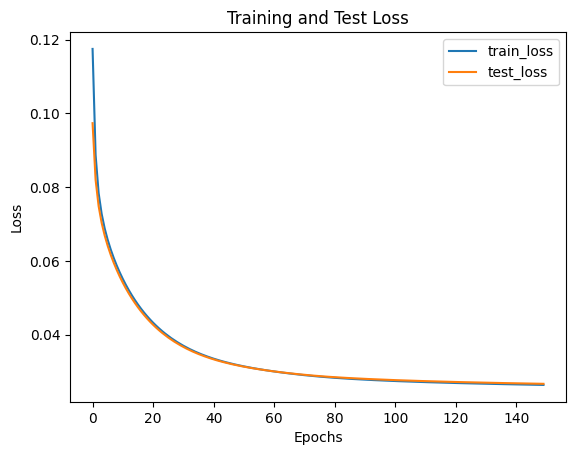

In [17]:
model = KerasClassifier(build_fn=create_model, verbose=0)

# \fit model with 150 epochs and use batch size of 32

history = model.fit(train_data, train_label, epochs = 150, batch_size = 32, verbose = 1, validation_data = (test_data, test_label))

# TODO: implement model evaluation and print/graph anything needed for visualization

# graph loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
import pandas as pd

# save and example of how to use model for prediction
# model.model.save("../elderly_activity_model.h5")

loaded_model = load_model("../elderly_activity_model.h5")

input_data = pd.DataFrame({
            'time': [544.00],
            'room': [2],
            'frontal accel': [0.16650],
            'vertical accel': [1.0798],
            'lateral accel': [0.100350],
            'antenna id': [1],
            'rssi': [-0.597015],
            'phase': [0.15493],
            'frequency': [922.75],
            'gender': [1],
            # 'consecutiveness': [1],
            # 'activity': [4],
            'acceleration': [0.038066],
            # 'freq': [0.030495],
                }).values
#input_data = X
predictions = loaded_model.predict(input_data)
print(predictions)

1/1 [==============================] - 0s 32ms/step
[[0.32515225]]


   1/1761 [..............................] - ETA: 56s

1761/1761 [==============================] - 1s 593us/step
Threshold Range: 0.0019 0.3252
587/587 [==============================] - 0s 824us/step
Best F1-Score: 0.5792943001163241
Accuracy: 0.980743974727576
Recall: 0.4348079161816065
Precision: 0.867595818815331
Threshold: 0.17840000003203763


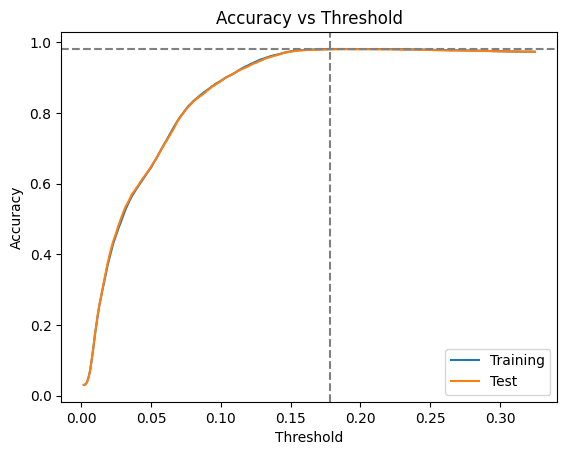

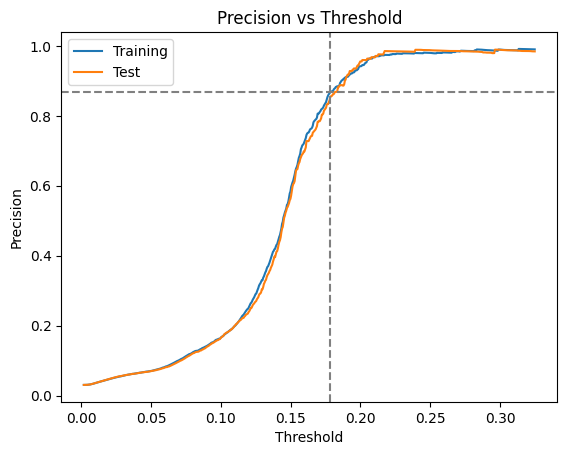

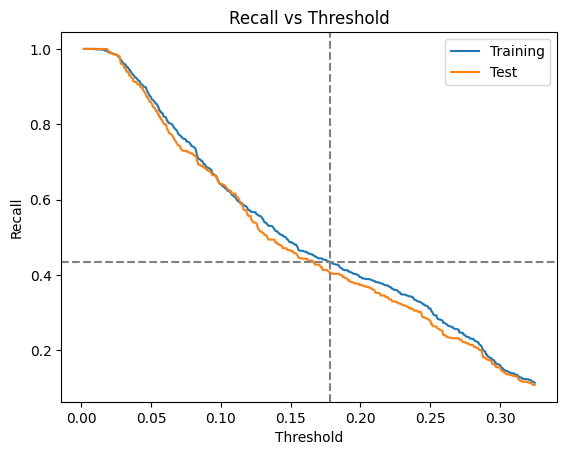

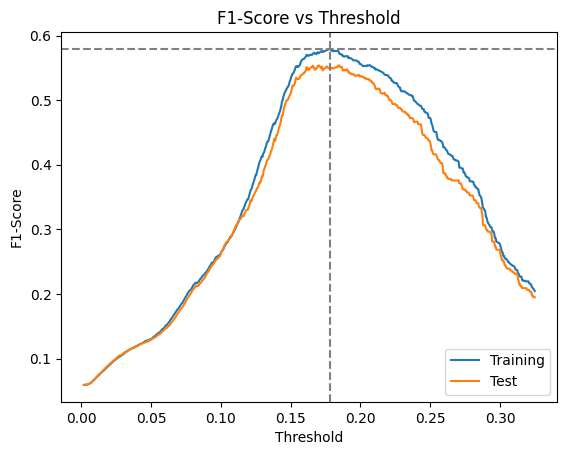

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold_history = []

train_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
train_pred = loaded_model.predict(train_data).flatten()
threshold = round(min(train_pred), 4)
max_threshold = round(max(train_pred), 4)
print('Threshold Range:', threshold, max_threshold)

test_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
test_pred = loaded_model.predict(test_data).flatten()

while threshold <= max_threshold:
    threshold_history.append(threshold)

    train_label_pred = (train_pred >= threshold).astype(int)
    train_history['accuracy'].append(accuracy_score(train_label, train_label_pred))
    train_history['precision'].append(precision_score(train_label, train_label_pred))
    train_history['recall'].append(recall_score(train_label, train_label_pred))
    train_history['f1'].append(f1_score(train_label, train_label_pred))

    test_label_pred = (test_pred >= threshold).astype(int)
    test_history['accuracy'].append(accuracy_score(test_label, test_label_pred))
    test_history['precision'].append(precision_score(test_label, test_label_pred))
    test_history['recall'].append(recall_score(test_label, test_label_pred))
    test_history['f1'].append(f1_score(test_label, test_label_pred))

    threshold += 0.0005

best_f1_index = np.argmax(train_history['f1'])
print('Best F1-Score:', train_history['f1'][best_f1_index])
print('Accuracy:', train_history['accuracy'][best_f1_index])
print('Recall:', train_history['recall'][best_f1_index])
print('Precision:', train_history['precision'][best_f1_index])
print('Threshold:', threshold_history[best_f1_index])

# Accuracy is the ratio of the number of correct predictions to the total number of predictions
# (for all labels i.e., positive and negative). (Lecture 14, slide 28)
plt.plot(threshold_history, train_history['accuracy'], label='Training')
plt.plot(threshold_history, test_history['accuracy'], label='Test')
plt.axvline(x=threshold_history[best_f1_index], color='gray', linestyle='--')
plt.axhline(y=train_history['accuracy'][best_f1_index], color='gray', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.show()

# Precision is the fraction of positive predictions that are actually correct.
# It shows the accuracy of "positive" predictions. (Lecture 14, slide 46)
plt.plot(threshold_history, train_history['precision'], label='Training')
plt.plot(threshold_history, test_history['precision'], label='Test')
plt.axvline(x=threshold_history[best_f1_index], color='gray', linestyle='--')
plt.axhline(y=train_history['precision'][best_f1_index], color='gray', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.legend()
plt.show()

# Recall
plt.plot(threshold_history, train_history['recall'], label='Training')
plt.plot(threshold_history, test_history['recall'], label='Test')
plt.axvline(x=threshold_history[best_f1_index], color='gray', linestyle='--')
plt.axhline(y=train_history['recall'][best_f1_index], color='gray', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.legend()
plt.show()

# Unlike Accuracy, F-score is resilient to imbalanced datasets. (Lecture 14, slide 28)
plt.plot(threshold_history, train_history['f1'], label='Training')
plt.plot(threshold_history, test_history['f1'], label='Test')
plt.axvline(x=threshold_history[best_f1_index], color='gray', linestyle='--')
plt.axhline(y=train_history['f1'][best_f1_index], color='gray', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.show()

In [39]:
# apply threshold on our prediction probabilities
threshold = threshold_history[best_f1_index]
predictions = (predictions >= threshold).astype(int)
print(f'number active = {(predictions == 1).sum()}')
print(f'number inactive = {(predictions == 0).sum()}')

number active = 1
number inactive = 0


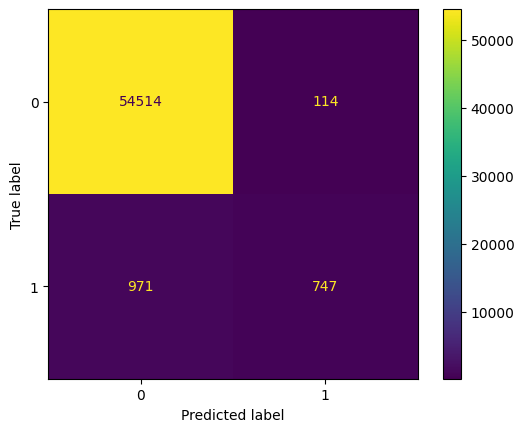

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_label_pred = (train_pred >= threshold).astype(int)
cm = confusion_matrix(train_label, train_label_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()